# Figure 4: model comparison

In [ ]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm

from statsmodels.stats.multitest import multipletests
from himalaya.scoring import correlation_score

from util import plot, subject, stats
from util.path import Path
from util.atlas import Atlas, get_brainmask
from constants import SUBS_STRANGERS, BLU, ORG

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('figures.mplstyle')

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
models = ['acoustic', 'articulatory', 'static', 'contextual']

modelname = "joint_split"
features = ["confounds", "stats", "acoustic", "articulatory", "LLM"]

FG_MASK = get_brainmask()

cache = 'default_task'
encmodel = f"encoding_{cache}"

cachedir = f"results/cache/figure4-comparison/{cache}/"
resultdir = f'figures/figure4/{encmodel}/{cache}'
!mkdir -p $resultdir
!mkdir -p $cachedir

encmodel, cache, cachedir

('encoding_default_task',
 'default_task',
 'results/cache/figure4-comparison/default_task/')

In [6]:
enc_sigmask = np.load(f'results/cache/figure2-{encmodel}/joint/{cache}/sigmask.npy')

# within-subject encoding comparison

In [76]:
results = defaultdict(list)
prod_results = defaultdict(list)
comp_results = defaultdict(list)
for modelname in models:
    respath = Path(
        root='results/' + encmodel,
        sub="000",
        datatype=modelname,
        ext=".hdf5",
    )

    for sub in tqdm(SUBS_STRANGERS, desc=modelname):
        respath.update(sub=f"{sub:03d}")
        if not respath.isfile():
            print("skip", sub)
            continue
        with h5py.File(respath, "r") as f:
            results[modelname].append(np.mean(f['cv_scores_prod'][:, -2] + f['cv_scores_comp'][:, -1], axis=0))
            prod_results[modelname].append(np.mean(f['cv_scores_prod'][:, -2], axis=0))
            comp_results[modelname].append(np.mean(f['cv_scores_comp'][:, -1], axis=0))

for modelname in models:
    results[modelname] = np.stack(results[modelname])
    prod_results[modelname] = np.stack(prod_results[modelname])
    comp_results[modelname] = np.stack(comp_results[modelname])

acoustic:  59%|█████▊    | 34/58 [00:00<00:00, 41.58it/s]

skip 163
skip 174


acoustic: 100%|██████████| 58/58 [00:01<00:00, 41.91it/s]


skip 63
skip 74


articulatory:  62%|██████▏   | 36/58 [00:00<00:00, 41.96it/s]

skip 163
skip 174


articulatory: 100%|██████████| 58/58 [00:01<00:00, 41.96it/s]


skip 63
skip 74


contextual: 100%|██████████| 58/58 [00:01<00:00, 41.08it/s]


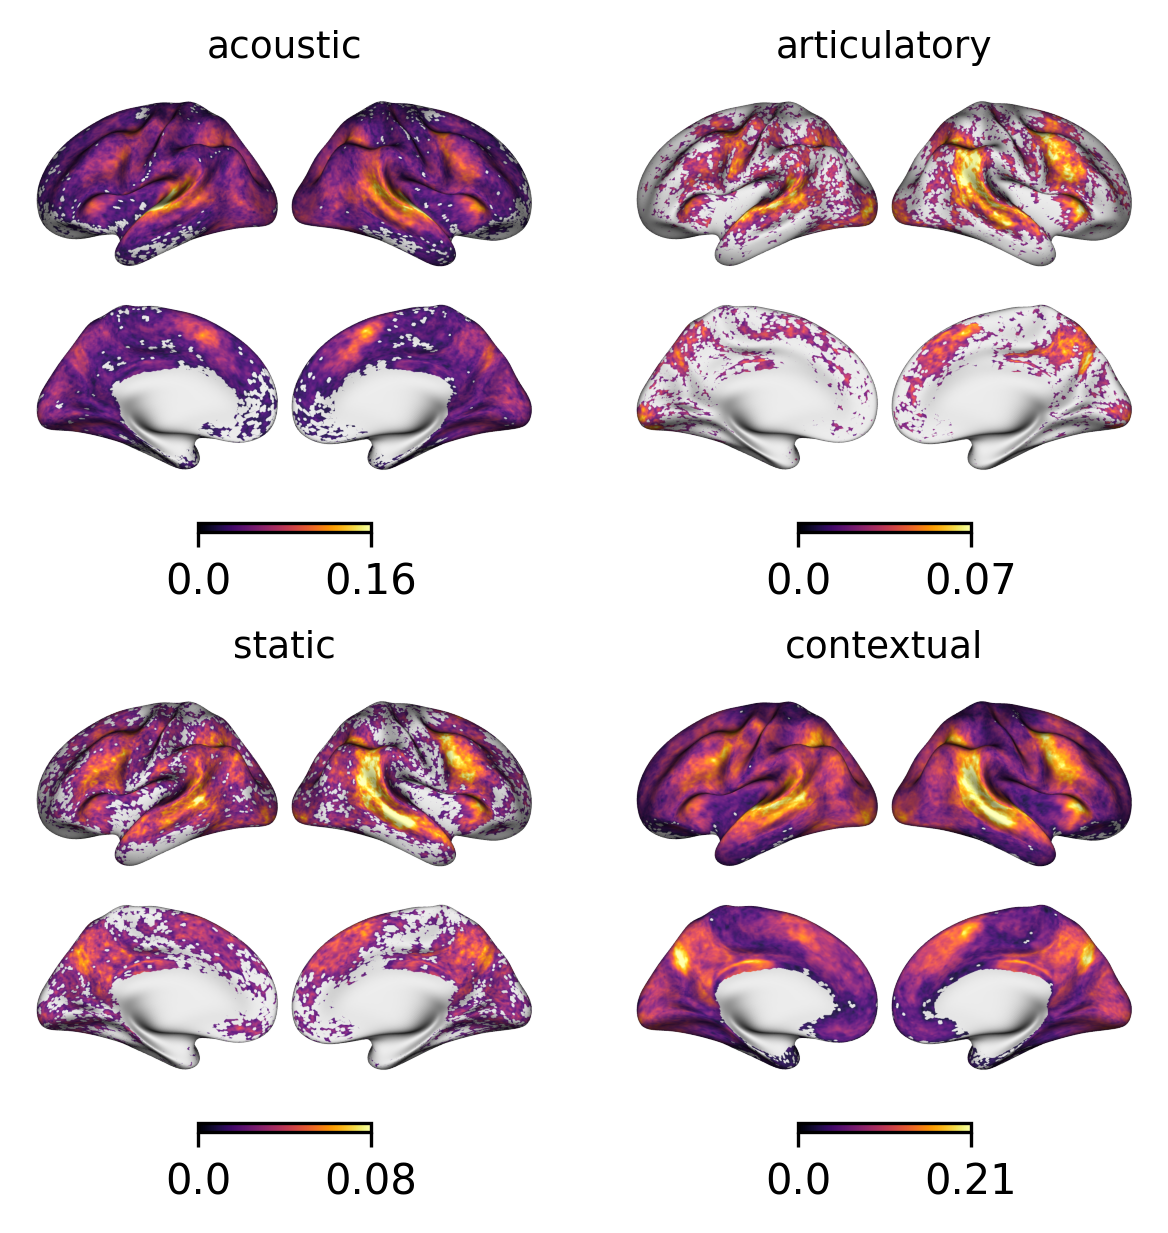

In [21]:
plot_models = models
fig, axes = plt.subplots(2, len(plot_models)//2, figsize=(4, 4), layout='constrained', dpi=300)

sigmask = None
for modelname, ax in zip(plot_models, axes.ravel()):

    values = results[modelname].mean(0)
    # values = prod_results[modelname].mean(0)
    # values = comp_results[modelname].mean(0)
    values = np.nan_to_num(values)

    sigmask = ~ stats.ttest_1samp(results[modelname], correlations=False, method='fdr_bh', alpha=0.05)
    min = values[~sigmask].min()
    # print(modelname, min, values[~sigmask].mean())

    plot.surface_plot(values, threshold=sigmask, fig=fig, ax=ax, vmin=0.00, vmax=None, cmap="inferno", title=modelname)

fig.show()

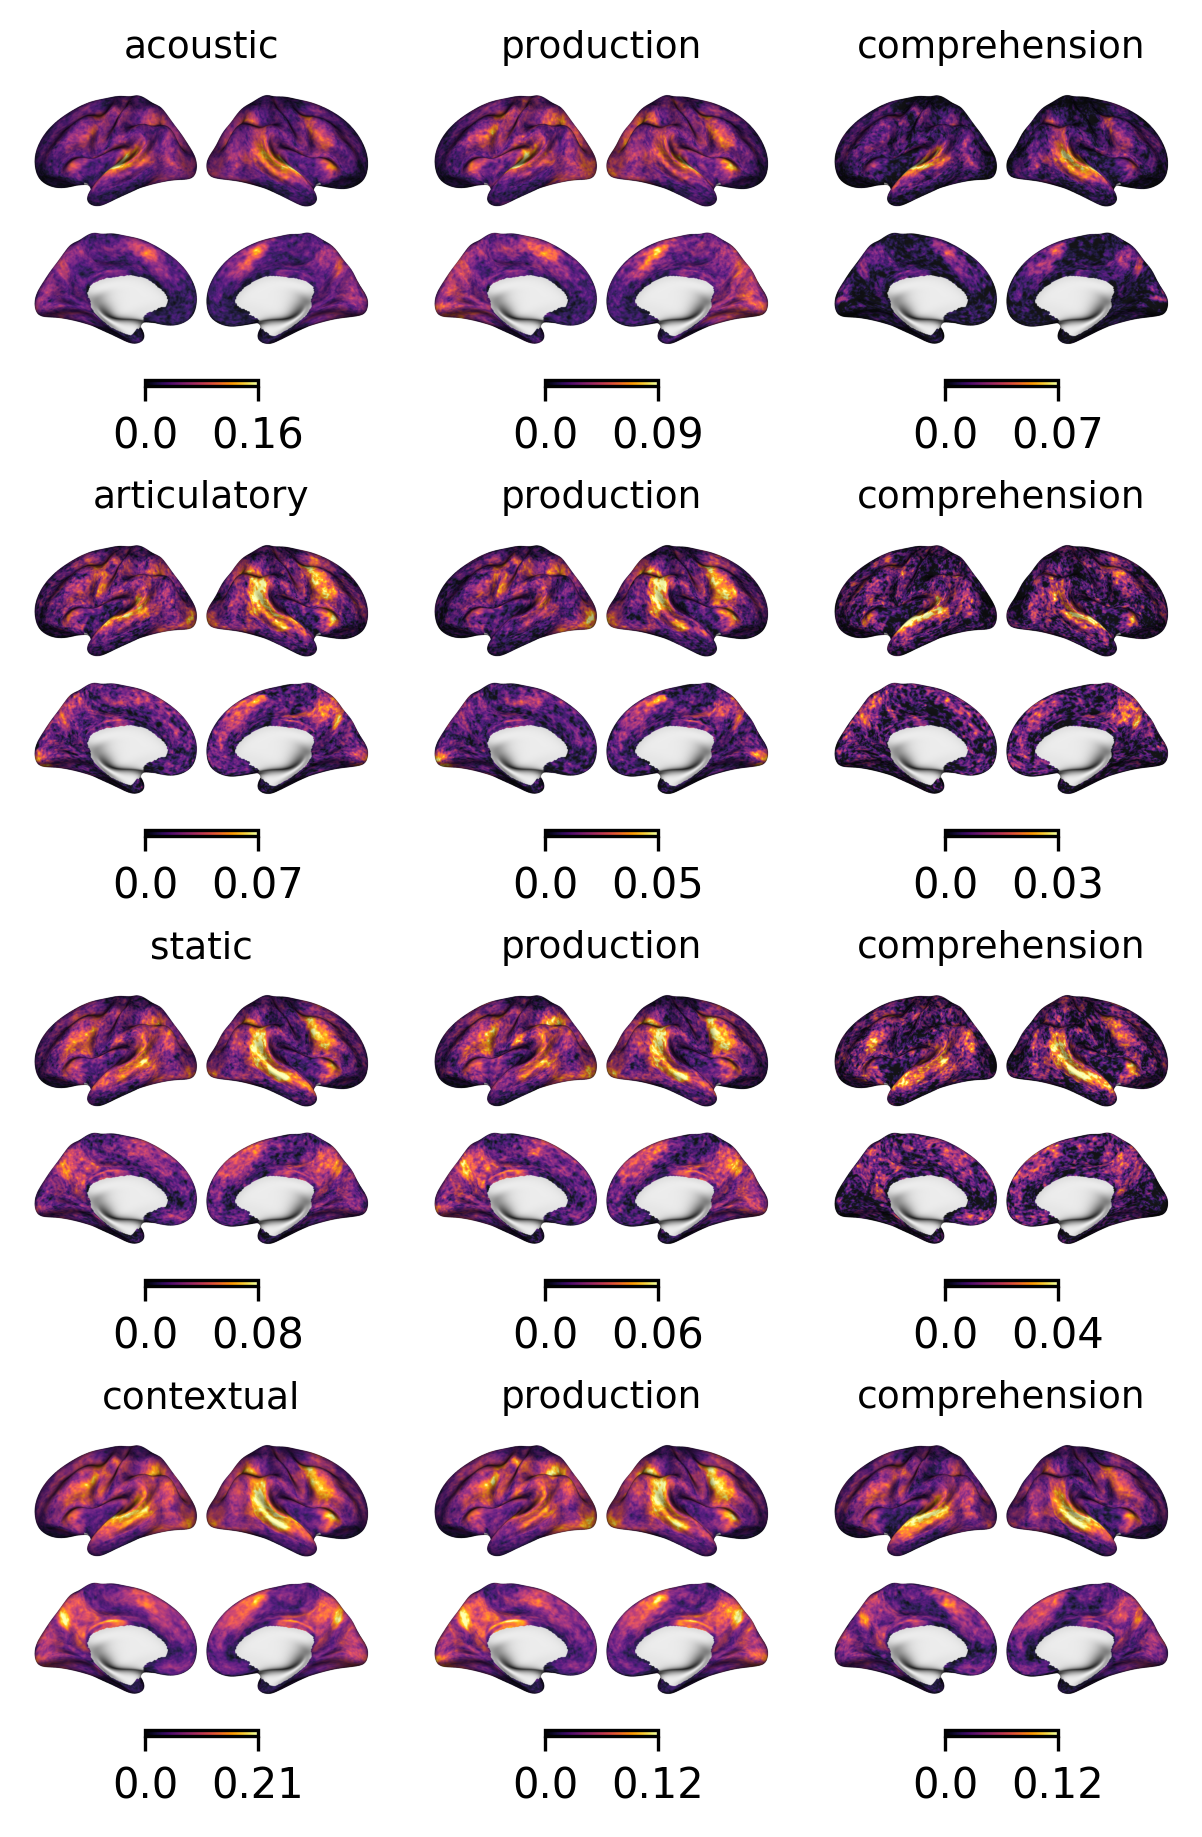

In [22]:
fig, axes = plt.subplots(len(models), 3, figsize=(4, 6), layout='constrained', dpi=300)

for i, modelname in enumerate(models):

    for j, result_dict in enumerate([results, prod_results, comp_results]):
        ax = axes[i, j]

        values = result_dict[modelname].mean(0)
        # values = np.nan_to_num(values)
        # sigmask = ~ stats.ttest_1samp(results[modelname], correlations=False, method='bonf', alpha=0.05)
        # min = values[~sigmask].min()
        plot.surface_plot(values, fig=fig, ax=ax, vmin=0, cmap="inferno")
    
    axes[i, 0].set_title(modelname)
    axes[i, 1].set_title('production')
    axes[i, 2].set_title('comprehension')

fig.show()

# bar plot compare

In [93]:
catlas = Atlas.load("custom_glasser_group")

df = pd.DataFrame(index=catlas.labels)
for modelname in models:
    df[modelname] = catlas.vox_to_parc(prod_results[modelname]).mean(0)
df

acoustic  articulatory    static  contextual
LH_EAC   0.077814      0.011011  0.012106    0.047525
LH_pSTG  0.041200      0.024710  0.030903    0.069421
LH_aSTG  0.037917      0.014158  0.024094    0.054088
LH_IFG   0.030693      0.015564  0.027072    0.054943
LH_FOP   0.037115      0.017317  0.021415    0.051993
LH_MFG   0.052098      0.028646  0.031155    0.077865
LH_SM    0.035136      0.018406  0.016476    0.048103
LH_SMA   0.041169      0.014851  0.022346    0.052749
LH_IPS   0.044239      0.023099  0.032785    0.074367
LH_TPJ   0.027542      0.013553  0.026096    0.061281
LH_PMC   0.028856      0.012243  0.025648    0.065775
RH_EAC   0.064744      0.009708  0.011247    0.041590
RH_pSTG  0.046779      0.034439  0.036223    0.086280
RH_aSTG  0.043048      0.020538  0.028880    0.066062
RH_IFG   0.035125      0.026237  0.029084    0.062495
RH_FOP   0.047962      0.028129  0.026202    0.071505
RH_MFG   0.050179      0.035809  0.038024    0.090593
RH_SM    0.029787      0.013434  0.011488    0.035714
RH_SMA   0.041006      0.017535  0.025571    0.061708
RH_IPS   0.044406      0.029672  0.030468    0.075601
RH_TPJ   0.035255      0.032145  0.036126    0.079936
RH_PMC   0.031692      0.017324  0.024756    0.064386

contextual
acoustic
static
articulatory


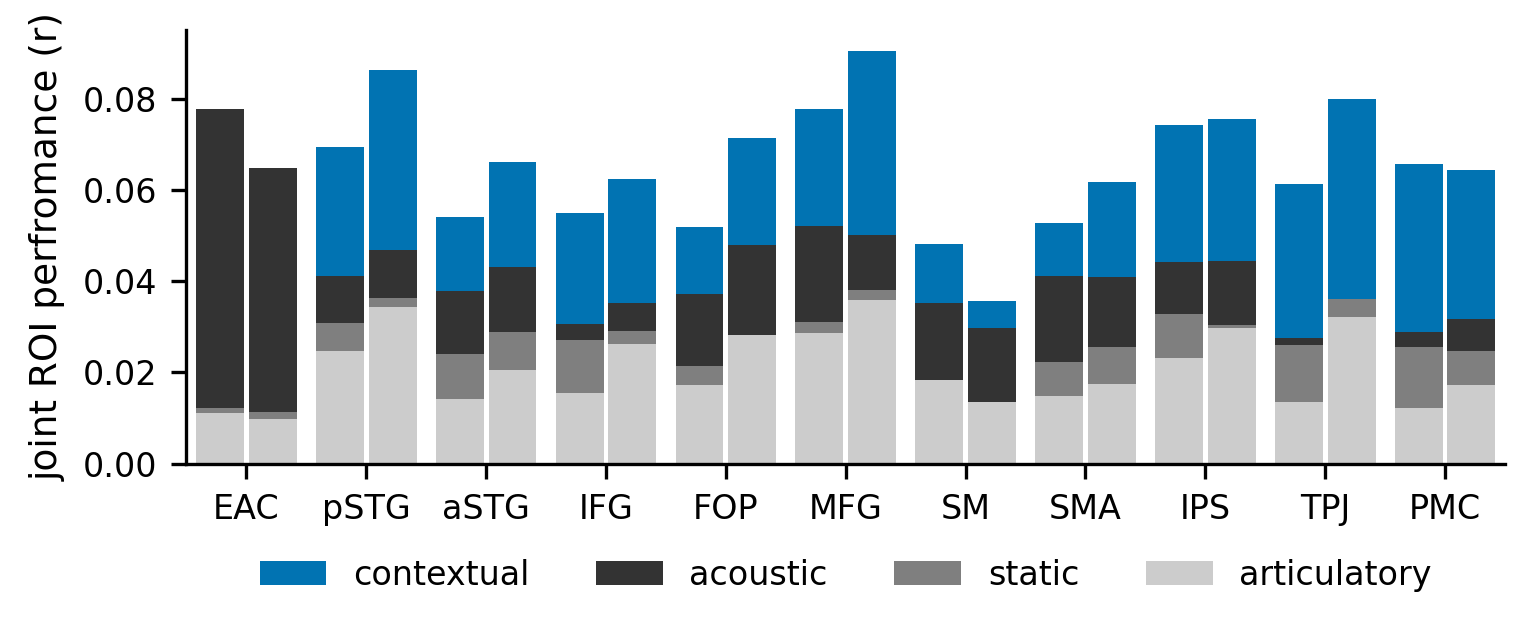

In [96]:
width = 0.4

fig, ax = plt.subplots(figsize=(5, 2), layout='constrained', dpi=300)

subdf1 = df.iloc[:len(df)//2]  # LH
subdf = df.iloc[len(df)//2:]  # RH
xlabels = subdf.index

feature_subset = ['contextual', 'acoustic', 'static', 'articulatory']
colors = ["#333333", "#7f7f7f", "#CCCCCC", BLU, ORG]
colors = [BLU, "#333333", "#7f7f7f", "#CCCCCC"]

xaxis = np.arange(len(xlabels))

bottom = np.zeros(len(xlabels))
for feature, color in zip(feature_subset, colors):
    values = subdf1[feature]
    ax.bar(xaxis - .02, values, -width, bottom=0, color=color, align='edge')
    bottom += values

bottom = np.zeros(len(xlabels))
for feature, color in zip(feature_subset, colors):
    values = subdf[feature]
    print(feature)
    ax.bar(xaxis + .02, values, width, label=feature, bottom=0, color=color, align='edge')
    bottom += values

ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels([label.split('_')[1] for label in xlabels])

# ax.set_ylim(0, 0.15)
# ax.set_yticks(np.arange(0, 0.16, .05))

gap = .1
ax.set_xlim(-width-gap, 10+width+gap)

ax.set_ylabel('joint ROI perfromance (r)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

fig.show()

In [97]:
catlas = Atlas.load("custom_glasser_group")

df = pd.DataFrame(index=catlas.labels)
for modelname in models:
    df[modelname] = catlas.vox_to_parc(comp_results[modelname]).mean(0)
df

acoustic  articulatory    static  contextual
LH_EAC   0.043973      0.015182  0.013670    0.066840
LH_pSTG  0.032090      0.016533  0.017951    0.069512
LH_aSTG  0.035135      0.020541  0.018904    0.083752
LH_IFG   0.014554      0.009165  0.013171    0.048697
LH_FOP   0.016070      0.008113  0.010561    0.039764
LH_MFG   0.019476      0.011475  0.011344    0.056516
LH_SM    0.010266      0.006481  0.007607    0.037001
LH_SMA   0.016968      0.008478  0.010509    0.046662
LH_IPS   0.015397      0.006509  0.007363    0.040185
LH_TPJ   0.014719      0.009950  0.013878    0.044131
LH_PMC   0.011875      0.009078  0.010342    0.044235
RH_EAC   0.040838      0.010892  0.011710    0.056347
RH_pSTG  0.045232      0.014134  0.023782    0.077670
RH_aSTG  0.041138      0.017392  0.023598    0.084989
RH_IFG   0.018881      0.006779  0.011742    0.046976
RH_FOP   0.019595      0.011404  0.015306    0.050926
RH_MFG   0.029203      0.012570  0.016522    0.065168
RH_SM    0.004909      0.006897  0.006416    0.031673
RH_SMA   0.018328      0.005613  0.011482    0.042095
RH_IPS   0.018438      0.007531  0.008822    0.043243
RH_TPJ   0.022483      0.012358  0.014680    0.049222
RH_PMC   0.015153      0.012591  0.011464    0.044970

contextual
acoustic
static
articulatory


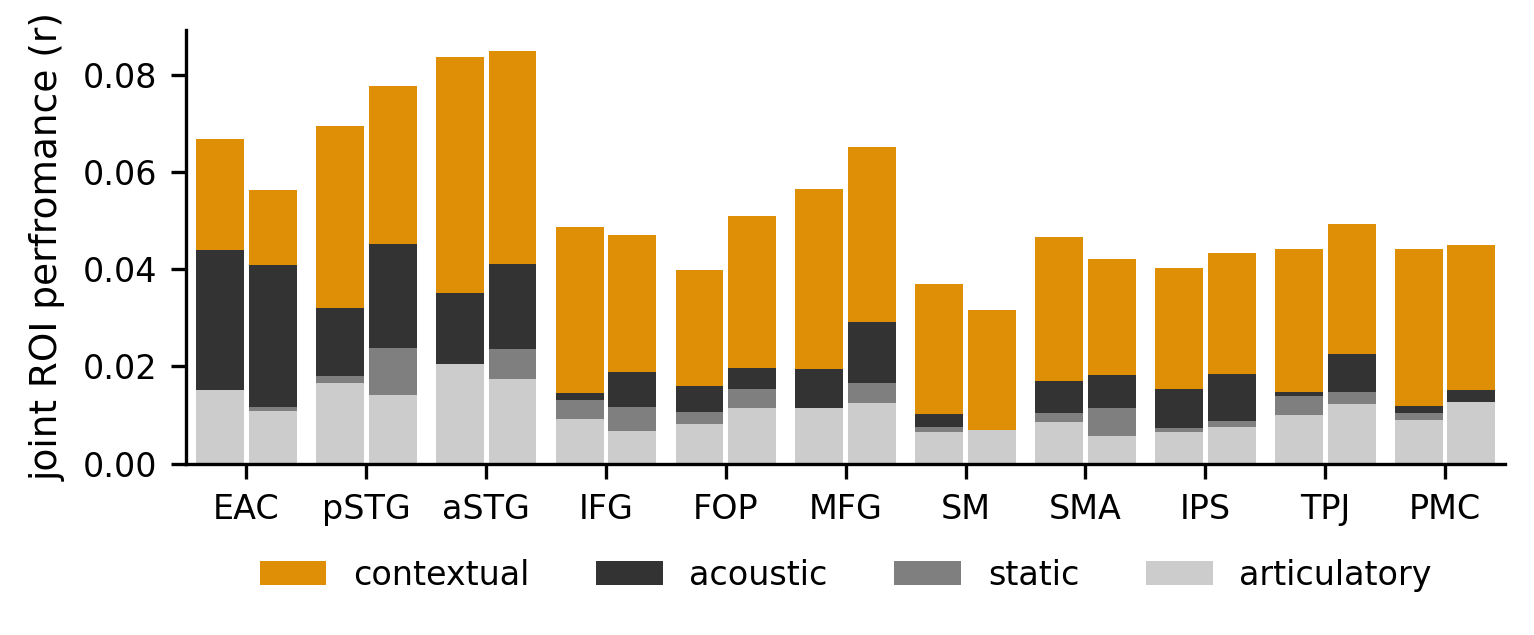

In [99]:
width = 0.4

fig, ax = plt.subplots(figsize=(5, 2), layout='constrained', dpi=300)

subdf1 = df.iloc[:len(df)//2]  # LH
subdf = df.iloc[len(df)//2:]  # RH
xlabels = subdf.index

feature_subset = ['contextual', 'acoustic', 'static', 'articulatory']
colors = [ORG, "#333333", "#7f7f7f", "#CCCCCC"]

xaxis = np.arange(len(xlabels))

bottom = np.zeros(len(xlabels))
for feature, color in zip(feature_subset, colors):
    values = subdf1[feature]
    ax.bar(xaxis - .02, values, -width, bottom=0, color=color, align='edge')
    bottom += values

bottom = np.zeros(len(xlabels))
for feature, color in zip(feature_subset, colors):
    values = subdf[feature]
    print(feature)
    ax.bar(xaxis + .02, values, width, label=feature, bottom=0, color=color, align='edge')
    bottom += values

ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels([label.split('_')[1] for label in xlabels])

# ax.set_ylim(0, 0.15)
# ax.set_yticks(np.arange(0, 0.16, .05))

gap = .1
ax.set_xlim(-width-gap, 10+width+gap)

ax.set_ylabel('joint ROI perfromance (r)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

fig.show()

## count significant voxels (skip)

In [11]:
enc_n_sig_voxels = {}
for modelname in models:
    sigmask = stats.ttest_1samp(results[modelname], correlations=False, method='bonf', alpha=0.05)
    enc_n_sig_voxels[modelname] = sigmask.sum()
    print(modelname, sigmask.sum())

acoustic 11139
articulatory 529
syntactic 3
static 4006
contextual 38957


## venn diagram unique/overlap (skip)

In [12]:
schaefer = Atlas.schaefer()

In [13]:
df_records = []
for modelname in models:
    prod_scores = prod_results[modelname]
    comp_scores = comp_results[modelname]

    # prod_scores = schaefer.vox_to_parc(prod_scores)
    # comp_scores = schaefer.vox_to_parc(comp_scores)
    
    prod_sigmask = stats.ttest_1samp(prod_scores, correlations=True, method='fdr_by', alpha=0.05, median_mask=True)
    comp_sigmask = stats.ttest_1samp(comp_scores, correlations=True, method='fdr_by', alpha=0.05, median_mask=True)

    intersection = np.logical_and(prod_sigmask, comp_sigmask)
    intersection_count = intersection.sum()

    prod_only = np.logical_and(prod_sigmask, np.logical_not(comp_sigmask))
    prod_count = prod_only.sum()

    comp_only = np.logical_and(comp_sigmask, np.logical_not(prod_sigmask))
    comp_count = comp_only.sum()

    # print(np.logical_or(prod_sigmask, comp_sigmask).sum(), prod_count, comp_count, intersection_count)
    # print(prod_count + comp_count + intersection_count)
    
    df_records.append((modelname, intersection_count, prod_count, comp_count))

metrics = ['both', 'production', 'comprehension']
df = pd.DataFrame(df_records, columns=['modelname'] + metrics)
df

modelname   both  production  comprehension
0      acoustic   4267       51794             43
1  articulatory      2       10147             20
2     syntactic      0           0              0
3        static    208       26641             15
4    contextual  41970       24536           1390

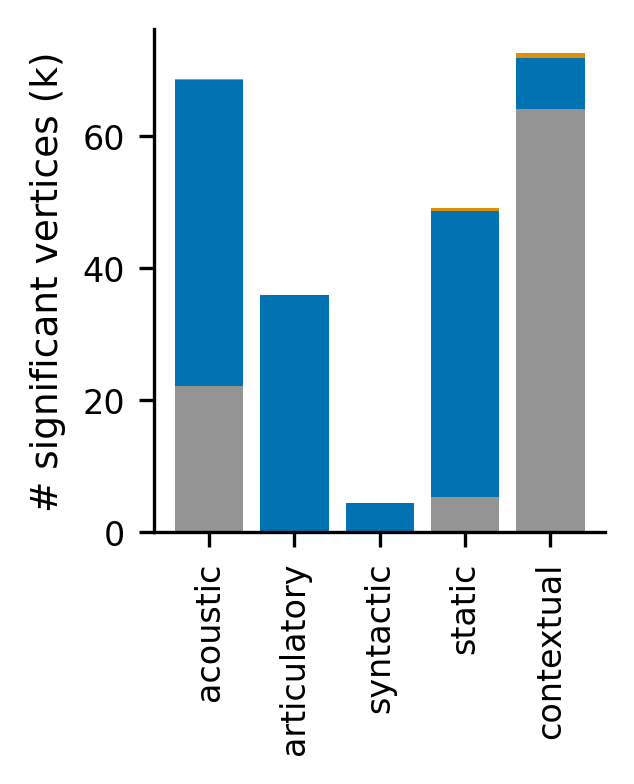

In [131]:
fig, ax = plt.subplots(figsize=(2, 2.5), layout='constrained', dpi=300)

xlabels = df['modelname']
bottom = np.zeros(len(xlabels))
GREEN = '#029e73'
GRAY = '#949494'
GRAY2 = '#CCCCCC'
colors = [GRAY, BLU, ORG]

xaxis = xlabels

width = 0.8
for feature, color in zip(metrics, colors):
    values = df[feature] / 1000
    p = ax.bar(xaxis, values, -width, bottom=bottom, color=color, label=feature)
    bottom += values

ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=90)

ax.set_ylabel('# significant vertices (k)')
# ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc='lower left', mode='expand', ncol=1)

fig.show()

## joint encoding performance violin plot (skip)

In [14]:
data = np.stack([results[modelname][..., FG_MASK].mean(0) for modelname in models])
data.shape

(5, 74947)

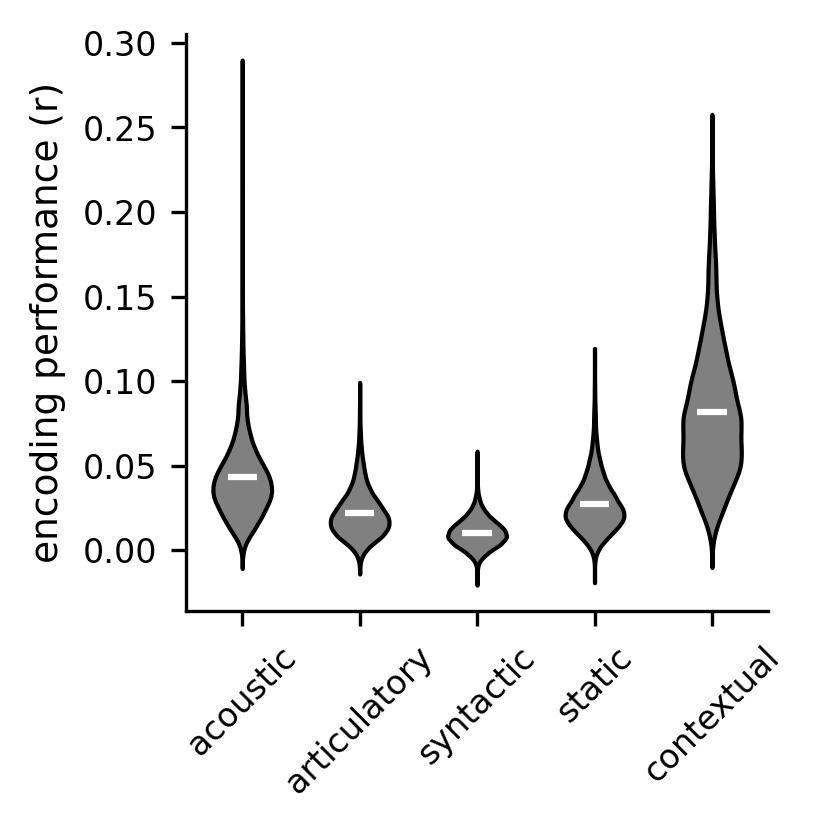

In [16]:
# https://matplotlib.org/stable/gallery/statistics/customized_violin.html
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
parts = ax.violinplot(data.T, vert=True, showmeans=True, showmedians=False, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
parts['cmeans'].set_color('white')
ax.set_xticks(range(1, len(models)+1))
ax.set_xticklabels(models, rotation=45)
ax.set_ylabel('encoding performance (r)')
fig.show()

## within-subject prod/comp overlap

In [77]:
A = np.zeros((len(models), len(models)))
for i, modelname1 in enumerate(models):
    prod_scores = prod_results[modelname1].mean(0)
    for j, modelname2 in enumerate(models):
        comp_scores = comp_results[modelname2].mean(0)
        A[i, j] = spearmanr(prod_scores, comp_scores).statistic
A

array([[0.48131965, 0.36338123, 0.36181586, 0.64267598],
       [0.48862854, 0.32953058, 0.34441338, 0.58206502],
       [0.5311053 , 0.36536245, 0.40258572, 0.65464302],
       [0.60200195, 0.41219072, 0.43989587, 0.73892543]])

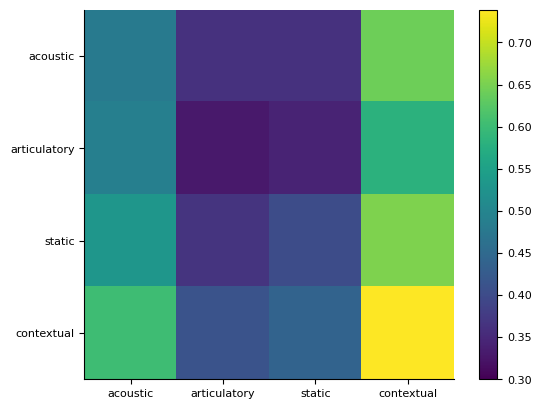

In [87]:
fig, ax = plt.subplots(dpi=100)
im = ax.imshow(A, vmin=0.3)
ax.set_xticks(range(len(models)))
ax.set_yticks(range(len(models)))
ax.set_xticklabels(models)
ax.set_yticklabels(models)
fig.colorbar(im, ax=ax)
fig.show()

In [19]:
# P/C correlation
intra_pc_corr = []
for modelname in models:
    prod_scores = prod_results[modelname].mean(0)
    comp_scores = comp_results[modelname].mean(0)
    corr = spearmanr(prod_scores, comp_scores)
    print(modelname, corr)
    intra_pc_corr.append(corr.statistic)

acoustic SignificanceResult(statistic=0.4813196513047454, pvalue=0.0)
articulatory SignificanceResult(statistic=0.32953058017758613, pvalue=0.0)
syntactic SignificanceResult(statistic=0.061614493851624874, pvalue=9.816252269246095e-70)
static SignificanceResult(statistic=0.4025857178375574, pvalue=0.0)
contextual SignificanceResult(statistic=0.7389254348870072, pvalue=0.0)


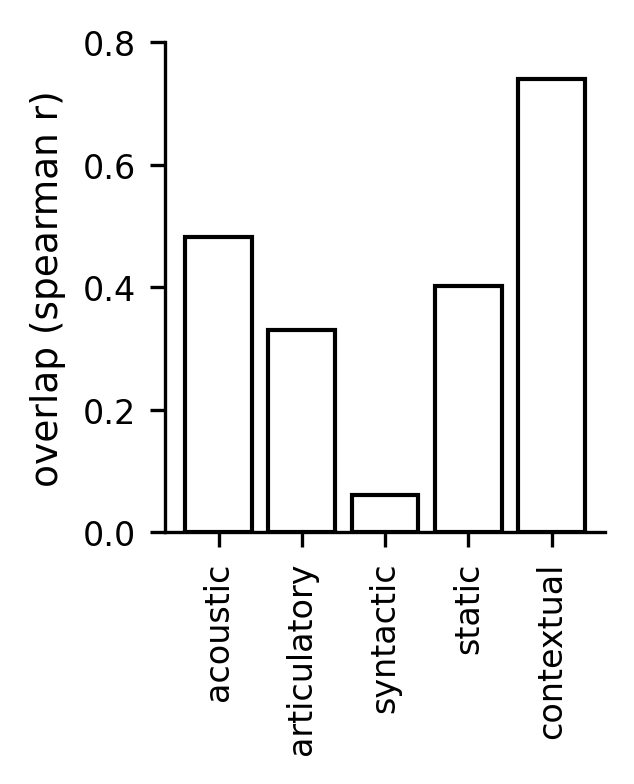

In [38]:
x = np.arange(len(models))  # the label locations
width = 0.8  # the width of the bars

fig, ax = plt.subplots(figsize=(2, 2.5), layout='constrained', dpi=300)

labels = ['within', 'between']

ax.bar(x + width, intra_pc_corr, width, facecolor='w', edgecolor='black')
ax.set_xticks(x + width, models)
ax.set_xticklabels(models, rotation=90)
ax.set_ylabel('overlap (spearman r)')
ax.set_ylim(0, .8)

fig.savefig(f'{resultdir}/prod-comp-spearman-overlap.svg')
fig.show()

In [18]:
# P/C percentage overlap
intra_pc_overlap = []
for modelname in models:
    prod_sigmask = ttest_1samp(prod_results[modelname], correlations=False, method='fdr_bh', alpha=0.05)
    comp_sigmask = ttest_1samp(comp_results[modelname], correlations=False, method='fdr_bh', alpha=0.05)
    # overlap = (prod_sigmask & comp_sigmask).mean()
    # out of all significantly predicted voxels, how many have both?
    overlap = (prod_sigmask & comp_sigmask).sum() / (prod_sigmask + comp_sigmask).sum()
    print(modelname, overlap, prod_sigmask.mean(), comp_sigmask.mean())
    intra_pc_overlap.append(overlap)

acoustic 0.2313024131439329 0.8538645573946585 0.19996582198134857
articulatory 0.012453837237512467 0.45068600166007516 0.007775499243201016
syntactic 0.0 0.07094380157218885 0.0
static 0.0786294750713815 0.6633953420243153 0.05595429910648894
contextual 0.8560521516644438 0.8867242810409648 0.7779771495532445


## variance partioning

In [4]:
models = ['joint_split', 'joint_split_nollm']

suffix = ''
suffix = '_exclusive'

prod_results = defaultdict(list)
comp_results = defaultdict(list)
for modelname in models:
    respath = Path(
        root='results/' + encmodel,
        sub="000",
        datatype=modelname,
        ext=".hdf5",
    )

    for sub in tqdm(SUBS_STRANGERS, desc=modelname):
        respath.update(sub=f"{sub:03d}")
        if not respath.isfile():
            print("skip", sub)
            continue
        with h5py.File(respath, "r") as f:
            prod_results[modelname].append(f[f'cv_scores_prod{suffix}'][...])
            comp_results[modelname].append(f[f'cv_scores_comp{suffix}'][...])

for modelname in models:
    prod_results[modelname] = np.stack(prod_results[modelname])
    comp_results[modelname] = np.stack(comp_results[modelname])

joint_split_nollm: 100%|██████████| 58/58 [00:01<00:00, 35.40it/s]


In [91]:
results = prod_results
# results = comp_results

In [92]:
full_acc = results['joint_split'].sum(2).mean(1)
nest_acc = results['joint_split_nollm'].sum(2).mean(1)

full_acc.shape, nest_acc.shape

((58, 81924), (58, 81924))

In [93]:
full_model = np.square(full_acc)
nest_model = np.square(nest_acc)
# full_model = full_acc
# nest_model = nest_acc

uniq_cont = full_model - nest_model
# uniq_cont = np.nan_to_num(np.sqrt(np.clip(uniq_cont, 0, 1)))
uniq_cont.shape

(58, 81924)

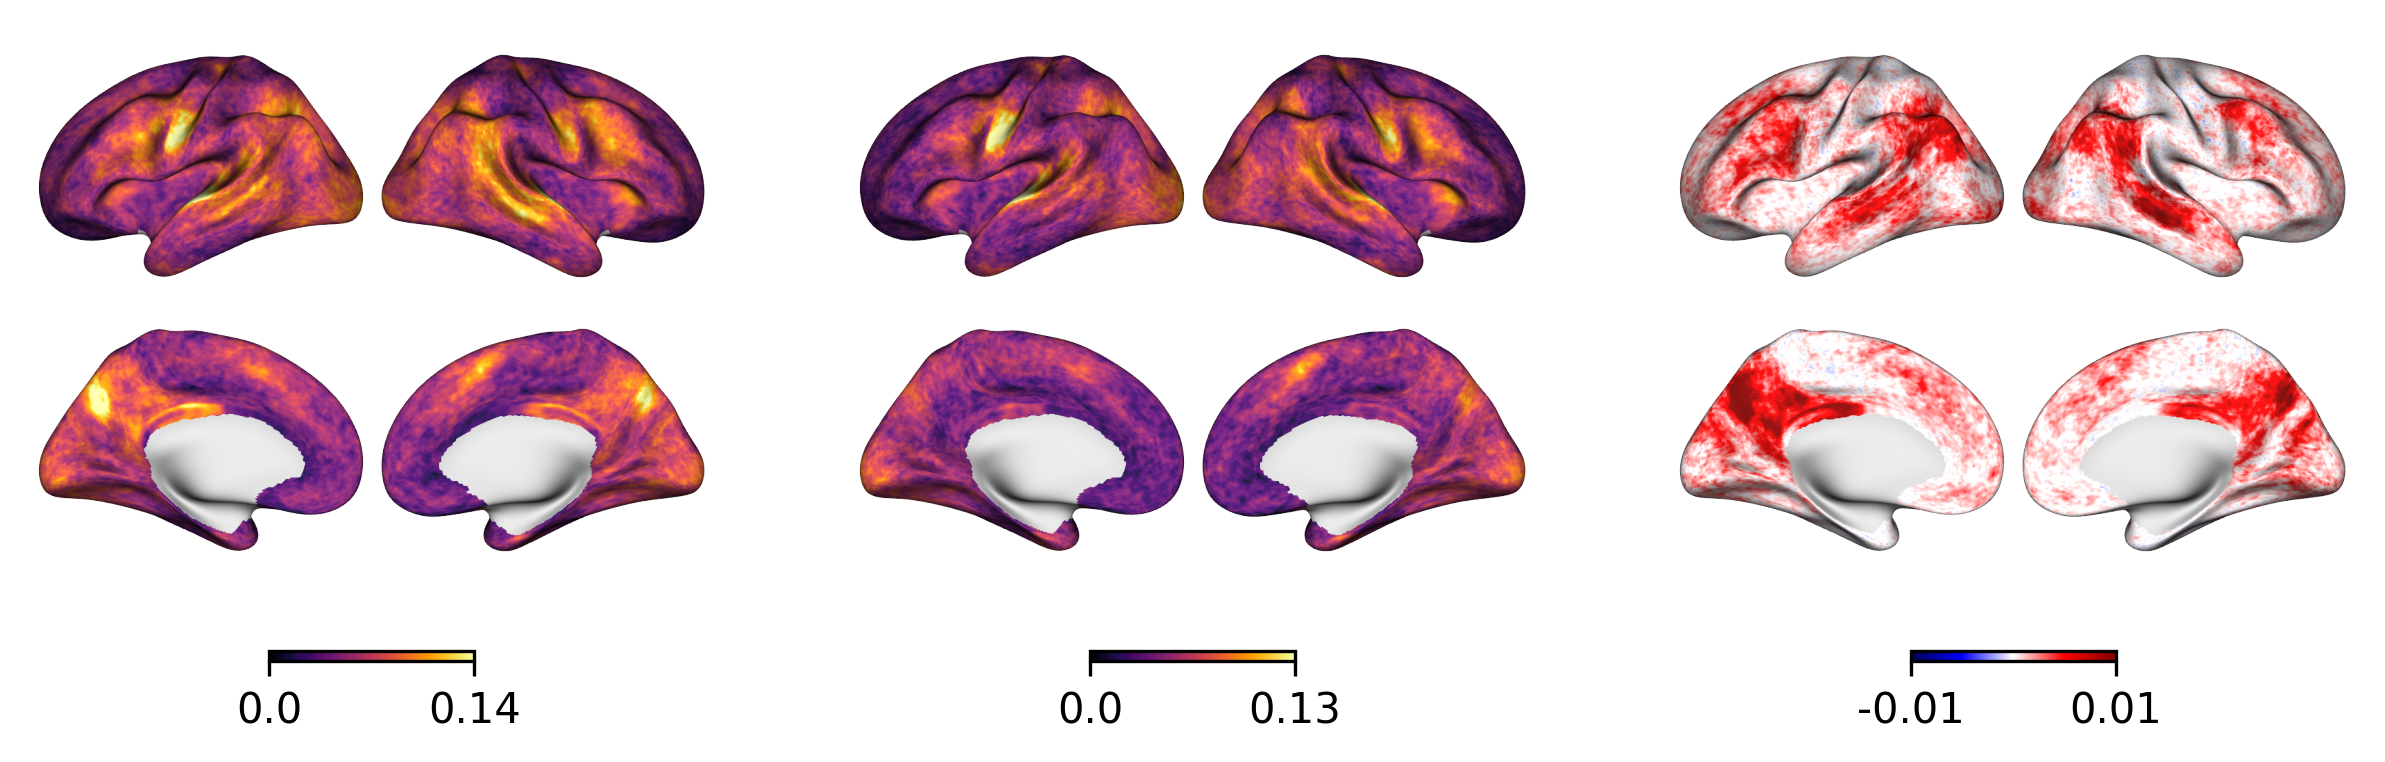

In [94]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), dpi=300)
plot.surface_plot(full_acc.mean(0), cmap='inferno', vmin=0, fig=fig, ax=axes[0])
plot.surface_plot(nest_acc.mean(0), cmap='inferno', vmin=0, fig=fig, ax=axes[1])
plot.surface_plot(uniq_cont.mean(0), cmap='seismic', fig=fig, ax=axes[2])
fig.show()

In [95]:
p_values = stats.ttest_1samp(uniq_cont, correlations=not True, alternative='greater')
sigmask = stats.correct_multiple_tests(p_values, method='fdr_bh', alpha=0.05)
sigmask.sum()

16295

In [96]:
uniq_cont = np.nan_to_num(np.sqrt(np.clip(uniq_cont, 0, 1)))
values = uniq_cont.mean(0)

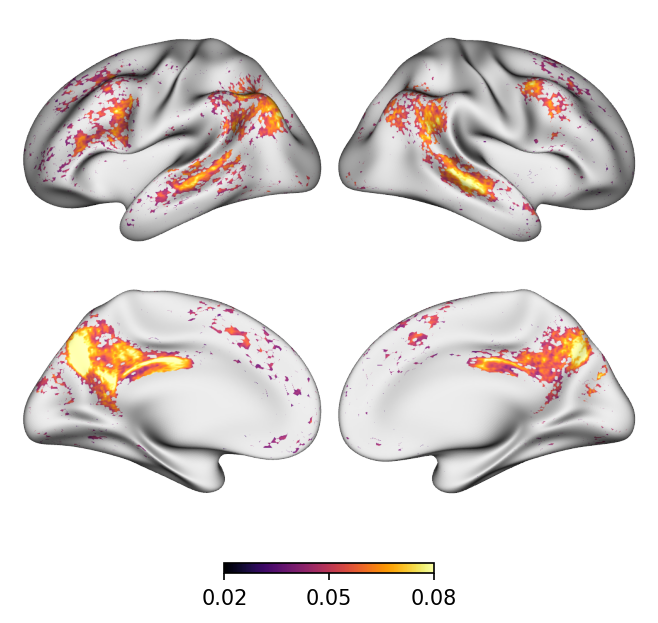

In [97]:
vmin = values[sigmask].min()
vmin, vmax = .02, .08
fig = plot.surface_plot(values, cmap='inferno', vmin=vmin, threshold=~sigmask)
fig.savefig(f'{resultdir}/variance-partition-enc-prod.svg')
fig.show()

### prod / comp VP

In [25]:
models = ['joint', 'joint_syntactic']

prod_results = defaultdict(list)
comp_results = defaultdict(list)
for modelname in models:
    respath = Path(
        root='results/' + encmodel,
        sub="000",
        datatype=modelname,
        ext=".hdf5",
    )

    for sub in tqdm(SUBS_STRANGERS, desc=modelname):
        respath.update(sub=f"{sub:03d}")
        if not respath.isfile():
            print("skip", sub)
            continue
        with h5py.File(respath, "r") as f:
            prod_results[modelname].append(np.mean(f['cv_scores_prod'][...].sum(1), axis=0))
            comp_results[modelname].append(np.mean(f['cv_scores_comp'][...].sum(1), axis=0))

for modelname in models:
    prod_results[modelname] = np.stack(prod_results[modelname])
    comp_results[modelname] = np.stack(comp_results[modelname])

joint_syntactic: 100%|██████████| 58/58 [00:02<00:00, 27.43it/s]


In [57]:
full_acc = prod_results['joint']#.mean(0)
nest_acc = prod_results['joint_syntactic']#.mean(0)
print(full_acc.shape, nest_acc.shape)

full_model = np.square(full_acc)
nest_model = np.square(nest_acc)
uniq_cont = full_model - nest_model
prod_uniq_cont = np.nan_to_num(np.sqrt(np.clip(uniq_cont, 0, 1)))

(58, 81924) (58, 81924)


In [60]:
full_acc = comp_results['joint']
nest_acc = comp_results['joint_syntactic']

full_model = np.square(full_acc)
nest_model = np.square(nest_acc)
uniq_cont = full_model - nest_model
comp_uniq_cont = np.nan_to_num(np.sqrt(np.clip(uniq_cont, 0, 1)))
comp_uniq_cont.shape

(58, 81924) (58, 81924)


(58, 81924)

In [67]:
prod_sigmask = ttest_1samp(prod_uniq_cont, correlations=True, method='bonf', alpha=0.01)#, alternative='greater')
prod_sigmask.sum()

25298

In [68]:
comp_sigmask = ttest_1samp(comp_uniq_cont, correlations=True, method='bonf', alpha=0.01)#, alternative='greater')
comp_sigmask.sum()

22868

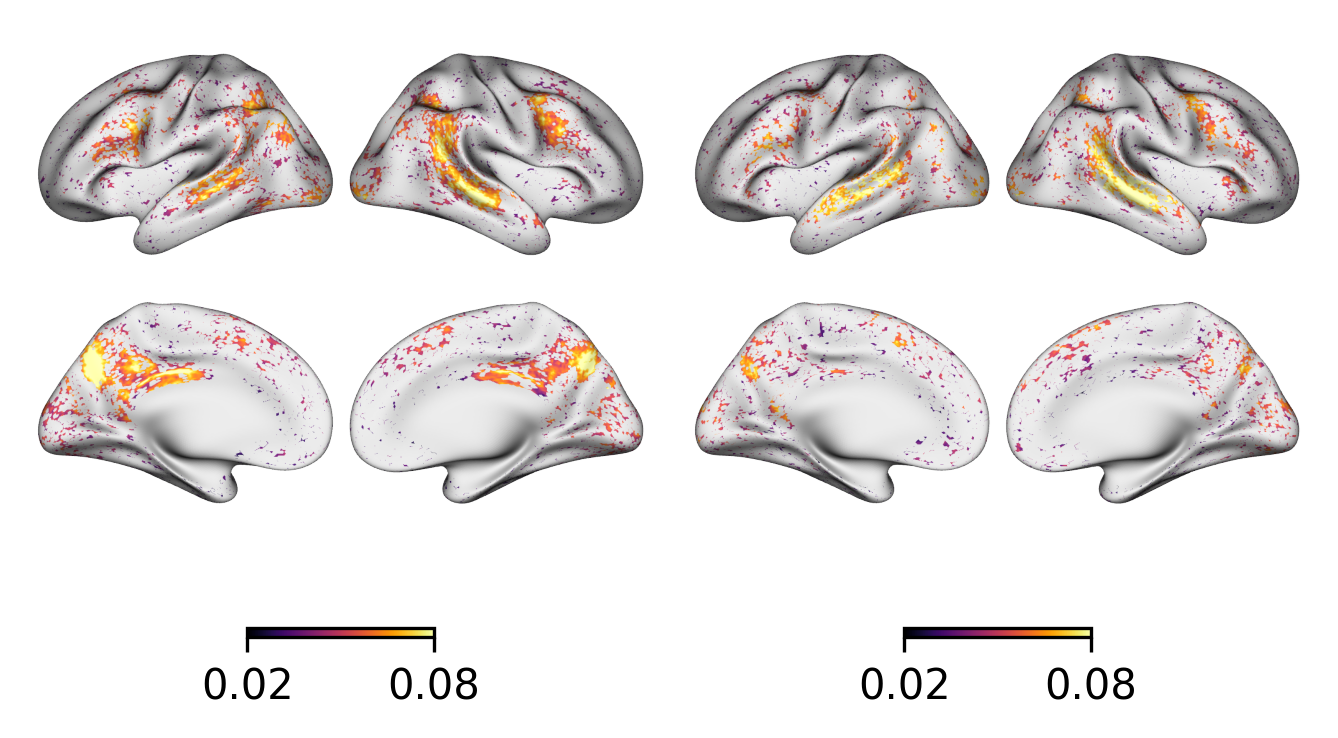

In [70]:
values1 = prod_uniq_cont.mean(0)
values2 = comp_uniq_cont.mean(0)

vmin1 = values1[prod_sigmask].min()
vmin2 = values2[comp_sigmask].min()

fig, axes = plot.two_brain_fig(dpi=300, layout='tight')
plot.surface_plot(values1, cmap='inferno', vmin=vmin1, fig=fig, ax=axes[0], threshold=~prod_sigmask)
plot.surface_plot(values2, cmap='inferno', vmin=vmin2, fig=fig, ax=axes[1], threshold=~comp_sigmask)
# fig.savefig(f'{resultdir}/variance-partition-enc.svg')
fig.show()

# MBC comparison

In [5]:
def get_mbc(modelname:str):
    mbc_scores = defaultdict(list)

    # use subA's predictions on subB's actual neural data
    for subA in tqdm(SUBS_STRANGERS):
        # load subA preds
        encpath = Path(root='results/' + encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
        with h5py.File(encpath, "r") as f:
            prod_predA = f["cv_preds"][:, -2]  # (5, 6, 240, 81924)
            comp_predA = f["cv_preds"][:, -1]
            prodmaskA = f["cv_prodmask"][...]

        # load subB preds
        subB = subject.get_partner(subA)
        encpath = Path(root='results/' + encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
        with h5py.File(encpath, "r") as f:
            nuis_predsB = f["cv_preds"][:, :-2].sum(1)

        dataB = subject.get_bold(subB, cache=cache)
        resB = dataB.reshape(5, 240, -1) - nuis_predsB

        compmaskA = ~prodmaskA

        for i in range(5):
            mbc_scores["prod"].append(correlation_score(prod_predA[i][prodmaskA[i]], resB[i][prodmaskA[i]]))
            mbc_scores["comp"].append(correlation_score(comp_predA[i][compmaskA[i]], resB[i][compmaskA[i]]))

    sub_mbc_prod = np.stack(mbc_scores["prod"])
    sub_mbc_comp = np.stack(mbc_scores["comp"])
    
    return sub_mbc_prod, sub_mbc_comp

In [127]:
models = ['acoustic', 'articulatory', 'syntactic', 'static', 'contextual']

results = []
for modelname in models:
    results.append(get_mbc(modelname))

100%|██████████| 58/58 [03:30<00:00,  3.64s/it]


In [128]:
# save
with h5py.File(f"{cachedir}/mbc.hdf5", "w") as f:
    for modelname, (prod, comp) in zip(models, results):
        f.create_dataset(name=f'{modelname}_prod', data=prod)
        f.create_dataset(name=f'{modelname}_comp', data=comp)

In [16]:
# read
results = []
with h5py.File(f"{cachedir}/mbc.hdf5", "r") as f:
    for modelname in models:
        results.append((f[f'{modelname}_prod'][...], f[f'{modelname}_comp'][...]))

## count sig voxels

In [21]:
mbc_n_sig_voxels = {}
for modelname, result in zip(models, results):
    values = (result[0] + result[1]) / 2
    sigmask = stats.ttest_1samp(values, correlations=False, method='bonf', alpha=0.05)
    mbc_n_sig_voxels[modelname] = sigmask.sum()
    print(modelname, sigmask.sum())

acoustic 3979
articulatory 7063
syntactic 1505
static 5080
contextual 16805


In [33]:
datum1 = []
datum2 = []
for modelname in model_order:
    datum1.append(enc_n_sig_voxels[modelname] / 1000)
    datum2.append(mbc_n_sig_voxels[modelname] / 1000)

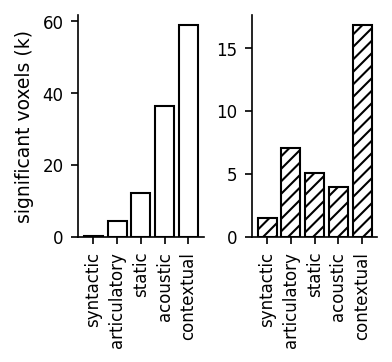

In [38]:
x = np.arange(len(model_order))  # the label locations
width = 0.8  # the width of the bars

fig, axes = plt.subplots(1, 2, figsize=(2.5, 2.3), layout='constrained', sharex=False)

colors = ['w', 'w']
hatches = [None, '////']
labels = ['within', 'between']
datums = (datum1, datum2)

for ax, attribute, measurement, color, hatch in zip(axes, labels, datums, colors, hatches):
    ax.bar(x + width, measurement, width, label=attribute, hatch=hatch, facecolor=color, edgecolor='black')
    ax.set_xticks(x + width, model_order)
    ax.set_xticklabels(model_order, rotation=90)

# fig.legend(loc='upper right', ncols=1)
axes[0].set_ylabel('significant voxels (k)')
plt.show()

## mbc violin plot

In [17]:
data = []
for i, modelname, result in zip(range(len(models)), models, results):
    values = (result[0] + result[1]) / 2
    data.append(values[..., FG_MASK])
data = np.stack(data).mean(1)
data.shape

(5, 74947)

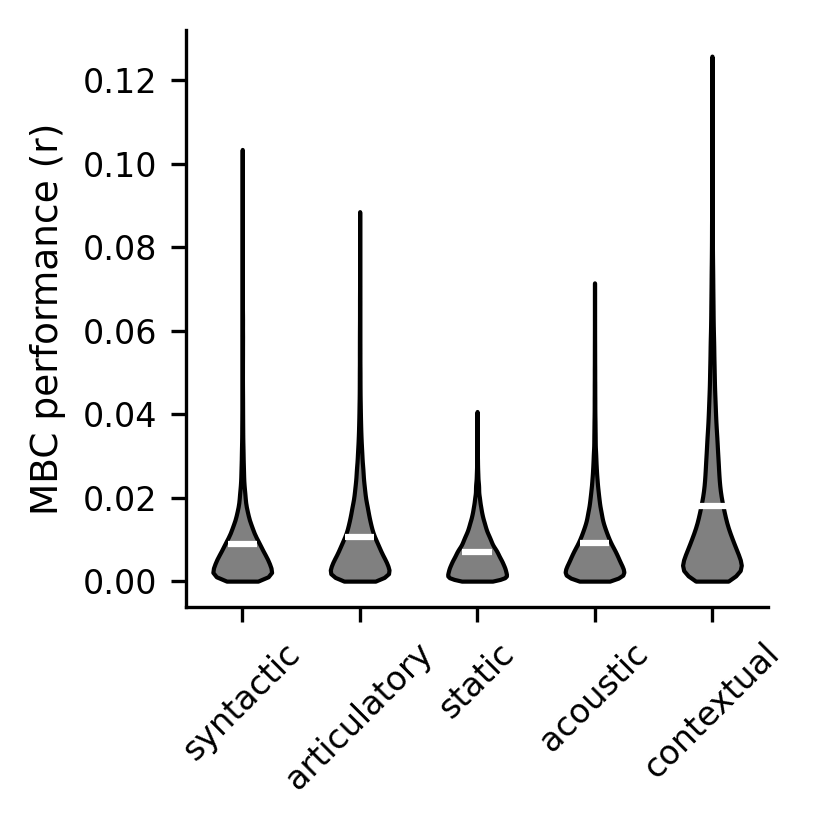

In [23]:
# https://matplotlib.org/stable/gallery/statistics/customized_violin.html
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
parts = ax.violinplot(np.abs(data.T), vert=True, showmeans=True, showmedians=False, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
parts['cmeans'].set_color('white')
ax.set_xticks(range(1, len(models)+1))
ax.set_xticklabels(model_order, rotation=45)
ax.set_ylabel('MBC performance (r)')
fig.show()

## mbc prod/comp overlap

In [10]:
# P/C correlation
inter_pc_corr = []
for i, modelname, result in zip(range(len(models)), models, results):
    corr = spearmanr(result[0].mean(0), result[1].mean(0))
    print(modelname, corr)
    inter_pc_corr.append(corr.statistic)

acoustic SignificanceResult(statistic=0.48268325579306454, pvalue=0.0)
articulatory SignificanceResult(statistic=0.6421874475678558, pvalue=0.0)
syntactic SignificanceResult(statistic=0.4618144461046909, pvalue=0.0)
static SignificanceResult(statistic=0.7236131805301309, pvalue=0.0)
contextual SignificanceResult(statistic=0.8144783450777355, pvalue=0.0)


In [21]:
inter_pc_overlap = []
for i, modelname, result in zip(range(len(models)), models, results):
    values = (result[0] + result[1]) / 2
    sigmask = stats.ttest_1samp(values, method='fdr_by', alpha=0.05)
    overlap = sigmask.mean()
    print(modelname, overlap)
    inter_pc_overlap.append(overlap)

acoustic 0.247678527405703
articulatory 0.46760895170789163
syntactic 0.17084394773605063
static 0.366368093790232
contextual 0.7773029829895637


In [63]:
# P/C percentage overlap out of all voxels
intra_pc_overlap = []
inter_pc_overlap = []
for i, modelname, result in zip(range(len(models)), model_order, results):
    prod_sigmask = ttest_1samp(prod_results[modelname], correlations=False, method='fdr_bh', alpha=0.05)
    comp_sigmask = ttest_1samp(comp_results[modelname], correlations=False, method='fdr_bh', alpha=0.05)

    # out of all significantly predicted voxels, how many have both?
    overlap = (prod_sigmask & comp_sigmask).sum() / (prod_sigmask + comp_sigmask).sum()
    # overlap = (prod_sigmask & comp_sigmask).mean()  # out of all voxels
    intra_pc_overlap.append(overlap)

    values = (result[0] + result[1]) / 2
    sigmask = stats.ttest_1samp(values, method='fdr_bh', alpha=0.05)
    overlap = sigmask.sum() / (prod_sigmask + comp_sigmask).sum()
    # overlap = sigmask.mean()
    inter_pc_overlap.append(overlap)

    print(modelname, intra_pc_overlap[-1], inter_pc_overlap[-1])

syntactic 0.0 0.5297655391378678
articulatory 0.19883942191259493 0.4202928179402098
static 0.4657970327815452 0.22233409339927152
acoustic 0.6686765108012032 0.3137134263057151
contextual 0.9563985877867719 0.5052689514451022


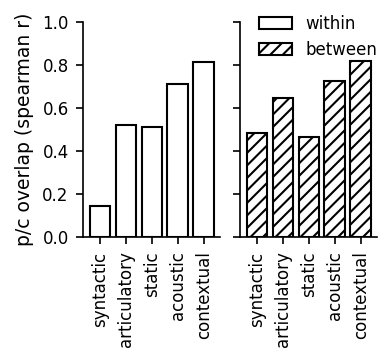

In [15]:
# P/C percentage overlap out of all voxels
x = np.arange(len(model_order))  # the label locations
width = 0.8  # the width of the bars

fig, axes = plt.subplots(1, 2, figsize=(2.5, 2.3), layout='constrained', sharex=False, sharey=True)

colors = ['w', 'w']
hatches = [None, '////']
labels = ['within', 'between']
# datums = (intra_pc_overlap, inter_pc_overlap)
datums = (intra_pc_corr, inter_pc_corr)

for ax, attribute, measurement, color, hatch in zip(axes, labels, datums, colors, hatches):
    ax.bar(x + width, measurement, width, label=attribute, hatch=hatch, facecolor=color, edgecolor='black')
    ax.set_xticks(x + width, model_order)
    ax.set_xticklabels(model_order, rotation=90)

fig.legend(loc='upper right', ncols=1)
axes[0].set_ylim(0, 1)
# axes[0].set_ylabel('overlap (% voxels)')
axes[0].set_ylabel('p/c overlap (spearman r)')
plt.show()

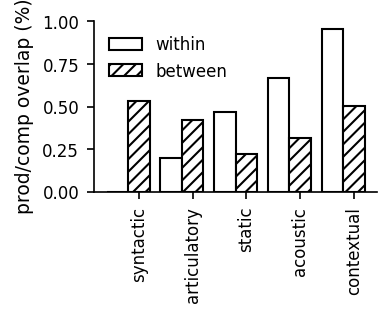

In [69]:
# P/C percentage overlap out of all sig voxels within each model
x = np.arange(len(model_order))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(2.5, 2), layout='constrained')

colors = ['w', 'w']
hatches = [None, '////']
labels = ['within', 'between']
datums = (intra_pc_overlap, inter_pc_overlap)

multiplier = 0
for attribute, measurement, color, hatch in zip(labels, datums, colors, hatches):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, hatch=hatch, facecolor=color, edgecolor='black')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('prod/comp overlap (%)')
ax.set_xticks(x + width, model_order)
ax.set_xticklabels(model_order, rotation=90)
ax.legend(loc='upper left', ncols=1)

plt.show()

## mbc brain plot

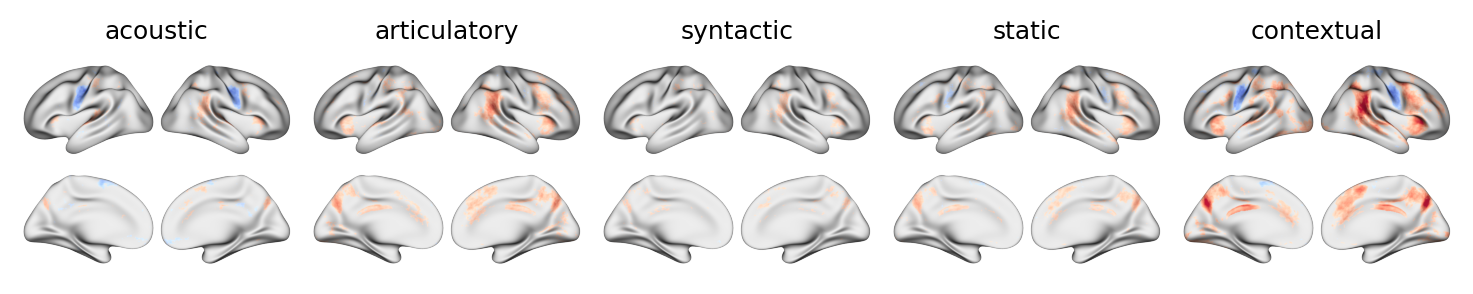

In [133]:
fig, axes = plt.subplots(1, len(models), figsize=(7.25, 6), layout='constrained', dpi=200)

for i, modelname, result, ax in zip(range(len(models)), models, results, axes):
    values = (result[0] + result[1]) / 2
    sigmask = ~ stats.ttest_1samp(values, method='fdr_by', alpha=0.05)
    plot.surface_plot(values.mean(0), threshold=sigmask, fig=fig, ax=ax, vmax=0.1, cmap="coolwarm", title=modelname, cbar=False)

fig.show()

## variance partitioning

In [7]:
def get_mbc_vp(modelname:str, pred_slice):
    mbc_scores = defaultdict(list)

    # use subA's predictions on subB's actual neural data
    for subA in tqdm(SUBS_STRANGERS):
        # load subA preds
        encpath = Path(root='results/' + encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
        with h5py.File(encpath, "r") as f:
            subA_preds = f["cv_preds"][:, pred_slice].sum(1)
            prodmaskA = f["cv_prodmask"][...]

        # load subB preds
        subB = subject.get_partner(subA)
        encpath = Path(root='results/' + encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
        with h5py.File(encpath, "r") as f:
            nuis_predsB = f["cv_preds"][:, :-2].sum(1)

        dataB = subject.get_bold(subB, cache=cache)
        resB = dataB.reshape(5, 240, -1) - nuis_predsB

        compmaskA = ~prodmaskA

        for i in range(5):
            mbc_scores["prod"].append(correlation_score(subA_preds[i][prodmaskA[i]], resB[i][prodmaskA[i]]))
            mbc_scores["comp"].append(correlation_score(subA_preds[i][compmaskA[i]], resB[i][compmaskA[i]]))

    sub_mbc_prod = np.stack(mbc_scores["prod"])
    sub_mbc_comp = np.stack(mbc_scores["comp"])
    
    return sub_mbc_prod, sub_mbc_comp

In [28]:
models = ['joint', 'joint_syntactic']
slices = [slice(-2, None), slice(1, None)]

results = []
for modelname, slc in zip(models, slices):
    print(modelname, slc)
    results.append(get_mbc_vp(modelname, slc))

joint slice(-2, None, None)


100%|██████████| 58/58 [03:59<00:00,  4.13s/it]


joint_syntactic slice(1, None, None)


100%|██████████| 58/58 [04:23<00:00,  4.55s/it]


In [29]:
# save
with h5py.File(f"{cachedir}/mbc-vp.hdf5", "w") as f:
    for modelname, (prod, comp) in zip(models, results):
        f.create_dataset(name=f'{modelname}_prod', data=prod)
        f.create_dataset(name=f'{modelname}_comp', data=comp)

In [41]:
# read
results = []
with h5py.File(f"{cachedir}/mbc-vp.hdf5", "r") as f:
    for modelname in models:
        results.append((f[f'{modelname}_prod'][...], f[f'{modelname}_comp'][...]))

In [30]:
res = {}
res['joint'] = (results[0][0] + results[0][1]) / 2
res['joint_syntactic'] = (results[1][0] + results[1][1]) / 2

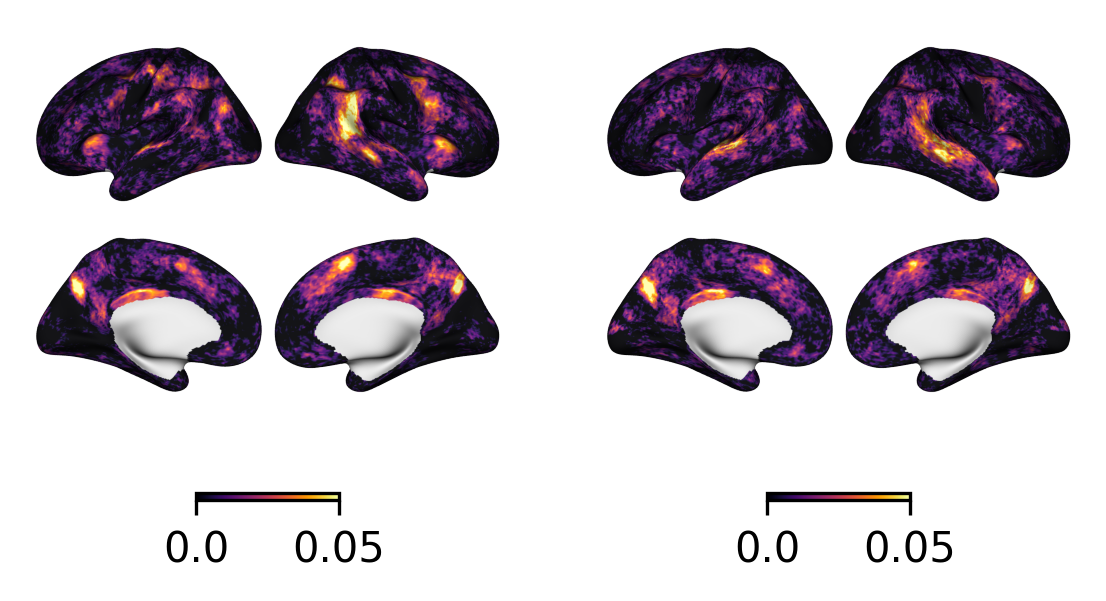

In [31]:
# prod comp for joint
fig, axes = plot.two_brain_fig(dpi=300)
plot.surface_plot(results[0][0].mean(0), cmap='inferno', vmin=0, fig=fig, ax=axes[0])
plot.surface_plot(results[0][1].mean(0), cmap='inferno', vmin=0, fig=fig, ax=axes[1])
fig.show()

In [32]:
full_acc = res['joint'].mean(0)
nest_acc = res['joint_syntactic'].mean(0)

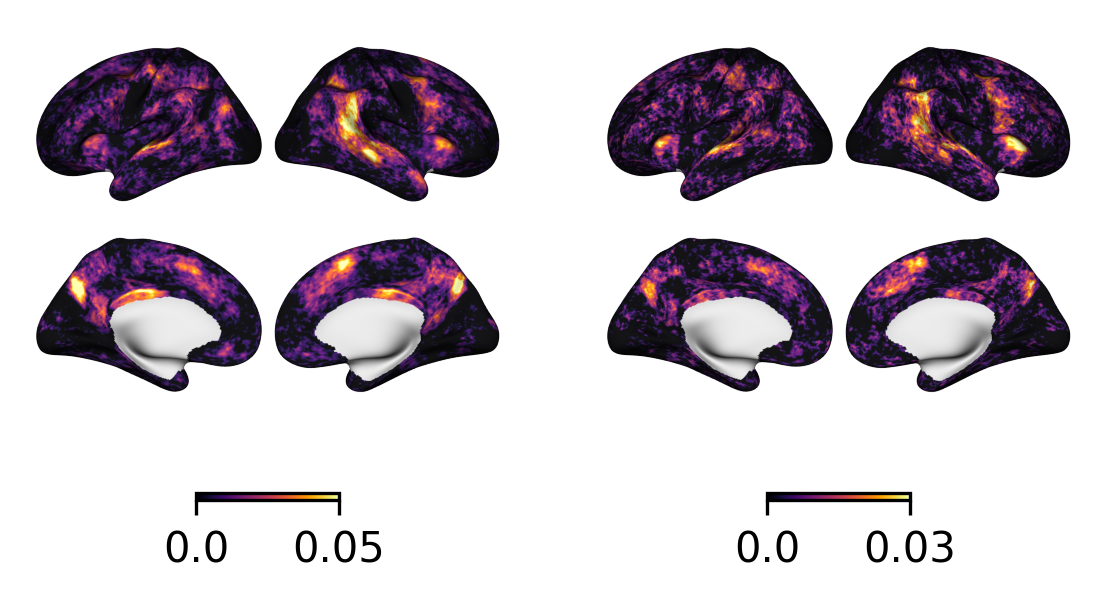

In [33]:
fig, axes = plot.two_brain_fig(dpi=300)
plot.surface_plot(full_acc, cmap='inferno', vmin=0, fig=fig, ax=axes[0])
plot.surface_plot(nest_acc, cmap='inferno', vmin=0, fig=fig, ax=axes[1])
fig.show()

In [35]:
res['joint'].shape

(290, 81924)

In [39]:
sub_joint_model_llm = res['joint']
sigmask = ttest_1samp(sub_joint_model_llm, correlations=True, method='fdr_by', alpha=0.01)#, alternative='greater')
sigmask.sum()

8103

In [40]:
full_model = np.square(full_acc)
nest_model = np.square(nest_acc)
uniq_cont = full_model - nest_model
values = np.nan_to_num(np.sqrt(np.clip(uniq_cont, 0, 1)))

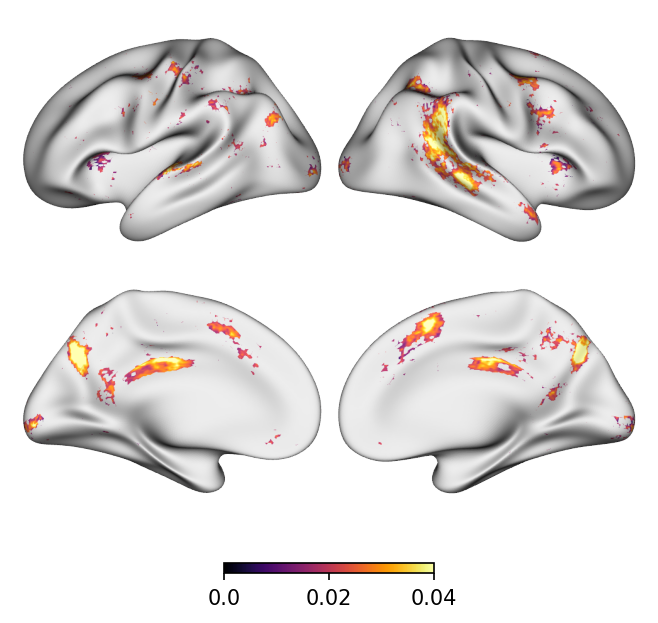

In [41]:
vmin = values[sigmask].min()
fig = plot.surface_plot(values, cmap='inferno', vmin=vmin, threshold=~sigmask)
fig.savefig(f'{resultdir}/variance-partition-mbc.svg')
fig.show()